<a href="https://colab.research.google.com/github/TaiseiYamana/StudyRecord/blob/main/MobileVit_training_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reference

pytorch cifar100 data auguments: 
https://github.com/weiaicunzai/pytorch-cifar100

MobilVitConfig argument: 
https://huggingface.co/docs/transformers/main/en/model_doc/mobilevit#transformers.MobileViTConfig

In [ ]:
git clone https://github.com/sksq96/pytorch-summary.git

In [12]:
cd pytorch-summary/

/content/pytorch-summary


In [13]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 57.5 MB/s eta 0:00:00


In [14]:
from transformers import MobileViTConfig, MobileViTForImageClassification
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import numpy as np
import random

import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR

image_size  = 32
patch_size = 8 # image_sizeの約数であること
n_classes = 100
seed = 1

lr = 1e-2
momentum = 0.9
weight_decay = 0.01
batch_size = 64

# 乱数生成シード値固定設定
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(0)
cudnn.deterministic = False
cudnn.benchmark = True

# MobileViTセットアップ
configuration = MobileViTConfig(image_size = image_size)
model = MobileViTForImageClassification(configuration).from_pretrained("apple/mobilevit-small")
#model = MobileViTForImageClassification.from_pretrained("apple/mobilevit-small")
model.classifier = nn.Linear(640, n_classes)
#torch.nn.init.normal_(model.classifier.weight, mean=0, std=1)
#model.classifier.bias.data.fill_(0.01)

In [17]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, (3, 32, 32))

RuntimeError: ignored

In [4]:
mean = [0.5070751592371323, 0.48654887331495095, 0.4409178433670343]
std = [0.2673342858792401, 0.2564384629170883, 0.27615047132568404]

#test_mean = [0.5088964127604166, 0.48739301317401956, 0.44194221124387256]
#test_mean = [0.2682515741720801, 0.2573637364478126, 0.2770957707973042]

train_transform = transforms.Compose([
            transforms.RandomCrop(image_size, padding=4),
            #transforms.RandomCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)])

test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)])

train_dataset = CIFAR100(root = './', train = True, transform = train_transform, download = True)
testTrain_dataset = CIFAR100(root = './', train = True, transform = test_transform, download = True)
test_dataset = CIFAR100(root = './', train = False, transform = test_transform, download = True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
testTrain_loader = DataLoader(testTrain_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader_dict = {'Train': testTrain_loader, 'Test': test_loader}

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./cifar-100-python.tar.gz to ./
Files already downloaded and verified
Files already downloaded and verified


In [5]:
params = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params.append(param)

#optimizer = optim.SGD([
#        {'params':  params[:-2], 'lr':1.0*lr},
#        {'params':  params[-1], 'lr':10.0*lr}
#    ], lr=lr, momentum=momentum)


optimizer = optim.AdamW([
        {'params':  params[:-2], 'lr':1.0*lr},
        {'params':  params[-1], 'lr':10.0*lr}
        ], lr = lr, weight_decay=weight_decay)


#scheduler = ExponentialLR(optimizer, gamma=0.95)
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0.001)

In [6]:
def linear_combination(x, y, epsilon):
    return (1 - epsilon) * x + epsilon * y

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon=0.1, reduction='mean'):
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction

    def forward(self, preds, target):
        n = preds.size()[-1]
        log_preds = F.log_softmax(preds, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return linear_combination(nll, loss/n, self.epsilon)

def train(model, train_loader, optimizer, criterion, device):
  model.train()

  for ite, (inputs, labels) in enumerate(train_loader):

    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs).logits

    loss = criterion(outputs, labels)
    _, preds = torch.max(outputs, 1)
    
    loss.backward()
    optimizer.step()


def test(model, test_loader_dict, phase, device):
  model.eval()
  test_loss = 0.0
  correct = 0

  with torch.no_grad():
    for inputs, labels in test_loader_dict[phase]:
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs).logits
      test_loss += F.cross_entropy(outputs, labels, size_average=False).item()

      _, preds = torch.max(outputs, 1)
      correct += torch.sum(preds == labels.data)
      
    test_loss /= len(test_loader_dict[phase].dataset)
    test_acc = correct / len(test_loader_dict[phase].dataset)

    print(f'{phase} loss : {test_loss:.4f} acc : {test_acc:.4f}')
  return test_loss, test_acc

In [7]:
# GPUが使用できるかを確認
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

criterion = LabelSmoothingCrossEntropy()

history = {}
history['train_loss'] = []
history['train_acc'] = []
history['test_loss'] = []
history['test_acc'] = []

num_epochs = 100
for epoch in range(1, num_epochs+1):
    print('-----------------------')
    print('Epoch {}/{}, lr: {}'.format(epoch,num_epochs, optimizer.param_groups[0]["lr"]))

    train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = test(model, test_loader_dict, 'Train', device)
    test_loss, test_acc = test(model, test_loader_dict, 'Test', device)

    #scheduler.step() 

    history['train_loss'].append(val_loss)
    history['train_acc'].append(val_acc.to('cpu').item())
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc.to('cpu').item())





-----------------------
Epoch 1/100, lr: 0.01


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train loss : 3.6657 acc : 0.1258
Test loss : 3.6912 acc : 0.1248
-----------------------
Epoch 2/100, lr: 0.01
Train loss : 3.4746 acc : 0.1565
Test loss : 3.5003 acc : 0.1505
-----------------------
Epoch 3/100, lr: 0.01
Train loss : 3.1657 acc : 0.2168
Test loss : 3.1997 acc : 0.2072
-----------------------
Epoch 4/100, lr: 0.01
Train loss : 2.9531 acc : 0.2441
Test loss : 2.9912 acc : 0.2376
-----------------------
Epoch 5/100, lr: 0.01
Train loss : 2.8274 acc : 0.2779
Test loss : 2.8890 acc : 0.2641
-----------------------
Epoch 6/100, lr: 0.01
Train loss : 2.7728 acc : 0.2855
Test loss : 2.8329 acc : 0.2751
-----------------------
Epoch 7/100, lr: 0.01
Train loss : 2.5923 acc : 0.3273
Test loss : 2.6567 acc : 0.3136
-----------------------
Epoch 8/100, lr: 0.01
Train loss : 2.6341 acc : 0.3252
Test loss : 2.7066 acc : 0.3046
-----------------------
Epoch 9/100, lr: 0.01
Train loss : 2.4197 acc : 0.3640
Test loss : 2.5054 acc : 0.3450
-----------------------
Epoch 10/100, lr: 0.01


In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as col

def plot_graph(values1, values2, rng, label1, label2):
    plt.plot(range(rng), values1, label=label1)
    plt.plot(range(rng), values2, label=label2)
    plt.legend()
    plt.grid()
    plt.show()  

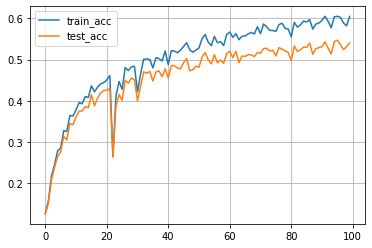

In [9]:
plot_graph(history['train_acc'], history['test_acc'], num_epochs,'train_acc', 'test_acc')

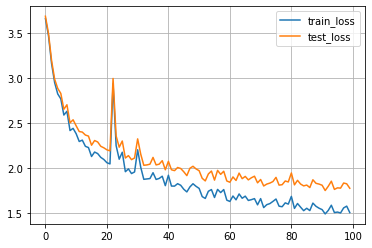

In [10]:
plot_graph(history['train_loss'], history['test_loss'], num_epochs,'train_loss', 'test_loss')